# status: simulator is working and initial results are compatible with Fisher estimates. 

# ToDo: experiment with Head structure. Compare:
 - [ ] `DefaultHead`
 - [ ]  linear compression to $O(10)$ features
 - [ ]  Convolution directly on $C_\ell$
 - [ ]  Fourier transform variants. Fourier transform and then:
     - [ ] DefaultHead
     - [ ] linear compression
     - [ ] MaxPooling
     - [ ] feature choice (important frequency bins) by hand using "gradient" of simulator

In [1]:
from classy import Class
#%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import swyft

In [3]:
fpr=np.loadtxt("fake_planck_realistic.dat")

for now hold $\tau$ fixed

In [218]:
'''simulator'''
lmax=1536
fsky=0.6
#ell=np.array([2,10,50,100,200,300,400,500])
ell=np.array([l for l in range(2,1536)])
#ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)
Nltt=fpr[ell-2,1]

sigCV=np.sqrt(2/((2+ell)*fsky))
def simulator(omega_b, omega_cdm, theta, lnAs,
                   n_s, 
              #tau_reio, 
              sigma=0.1): 
    params = {
        'output': 'tCl lCl',
        'YHe': 0.25,
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        '100*theta_s': theta,
        'ln10^{10}A_s': lnAs,
        'n_s': n_s,
        'tau_reio': 0.054
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the whole code. Depending on your output, it will call the
    # CLASS modules more or less fast. For instance, without any
    # output asked, CLASS will only compute background quantities,
    # thus running almost instantaneously.
    # This is equivalent to the beginning of the `main` routine of CLASS,
    # with all the struct_init() methods called.
    cosmo.compute()

    # Access the lensed cl until l=2000
    cls = cosmo.lensed_cl(lmax)
    T=cosmo.T_cmb()
    cosmo.struct_cleanup()
    return cls['tt'][ell]*(T*1.e6)**2+Nltt#*ells


def model(params):
    """Model wrapper around simulator code."""
    mu = simulator(params['omega_b'], params['omega_cdm'], params['100*theta_s'], params['ln10^{10}A_s'],
                   params['n_s'], 
                   #params['tau_reio']
                  )
    return dict(mu=mu)

#noise from cosmic variance and fake_planck_realistic file
#another method: add beam/window with sig= w^-ell exp(ell^2 sigma^2)*sigCV. look up w and sigma for Planck
def noise(obs, params=None, sigma=1.0):
    """Associated noise model."""
    cltt= obs['mu']
    #return {'mu': cltt*(1+np.random.normal(0,1,size=cltt.shape)*sigCV)}
    return {'mu': cltt*(1+np.random.normal(loc=0,scale=1,size=sigCV.shape)*sigCV)}

define fiducial cosmology

In [219]:
par={'omega_b': 0.0224,
    'omega_cdm': 0.120,
    '100*theta_s': 1.0411,
    'ln10^{10}A_s': 3.0753,
    'n_s':0.965,
    #'tau_reio': 0.054,
    }

Asimov data

In [220]:
obs=model(par)
#obs=noise(model(par))

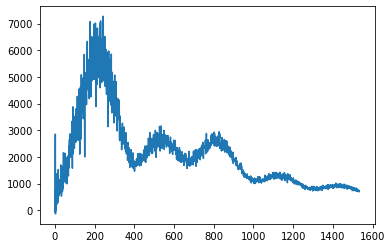

In [221]:
plt.plot(noise(model(par))['mu']*ells)

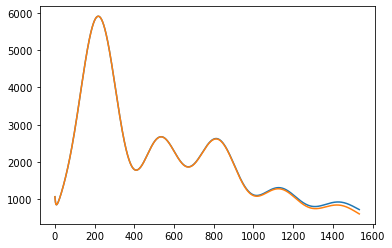

In [222]:
plt.plot(obs['mu']*ells);
plt.plot(model(par)['mu']*ells-Nltt*ells);

look at some deviations

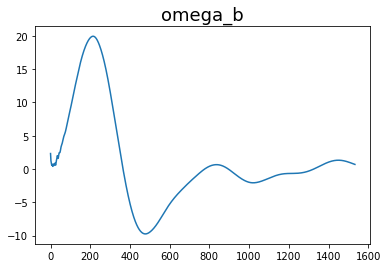

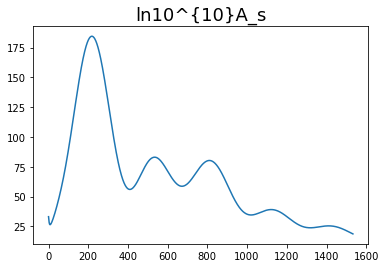

In [126]:
for i,k in enumerate(par.keys()):
    plt.figure()
    plt.title(k,fontsize=18);
    parr=dict(par)
    parr[k]=par[k]*(1+1e-2)
    m1=(model(parr)['mu'])*ells
    m2=obs['mu']*ells
    plt.plot(m1-m2);

Compute the Fisher matrix $F_{ij} = \sum_\ell \frac{1}{\delta C_\ell^2}\partial_{\theta_i}C_\ell \partial_{\theta_j} C_\ell$

finite derivative

In [127]:
obss=model(par)
eps=1e-2
def finiteD(k):
    parr=dict(par)
    parr[k]=par[k]*(1+eps)
    parr2=dict(par)
    parr2[k]=par[k]*(1-eps)
    m1=model(parr)['mu']
    m2=model(parr2)['mu']
    return (m1-m2)/(par[k]*(2*eps))

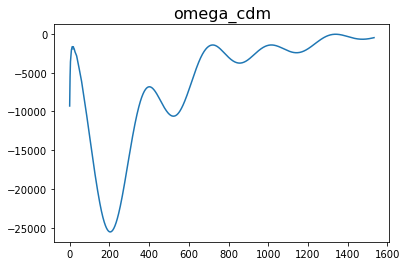

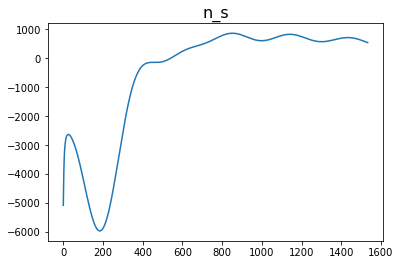

In [128]:
for k in par.keys():
    plt.figure()
    plt.title(k, fontsize=16)
    plt.plot(finiteD(k)*ells);

Fisher matrix

In [143]:
F=np.zeros((5,5))
for i in range(5):
    for j in range(i,5):
        key1=list(par.keys())[i]
        key2=list(par.keys())[j]
        d1=finiteD(key1)
        if i != j: 
            d2=finiteD(key2) 
        else: 
            d2=d1
        F[i,j]=np.sum(d1*d2/((sigCV*(obs['mu']))**2))

In [144]:
for i in range(5):
    for j in range(i):
        F[i,j] = F[j,i]

In [145]:
Finv=np.linalg.inv(F)

from the Fisher matrix, the expected $1\sigma$ for parameter $i$ is given by $\sqrt{(F^{-1})_{ii}}$. If all other parameters are fixed, then we have $\sigma_E=1/\sqrt{F_{ii}}$

In [146]:
sigE=[]
for i in range(5): sigE.append(1/np.sqrt(F[i,i]));
sigs=[]
for i in range(5): sigs.append(np.sqrt(Finv[i,i]));

In [147]:
sigs

[0.0002935419565602032,
 0.0030750013340409056,
 0.0006887547509717173,
 0.0077705648987198,
 0.00770090537653643]

In [148]:
sigE

[0.00023661387596287238,
 0.0008658119074936643,
 0.000541649813503282,
 0.0017483630643451479,
 0.0027451029691566075]

Check linearity of simulator over $\pm 5\sigma$ range

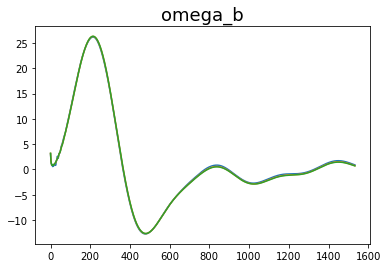

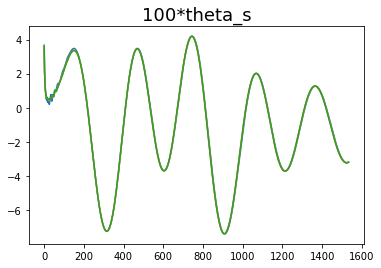

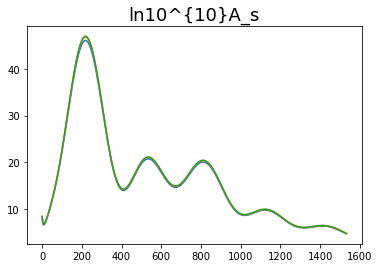

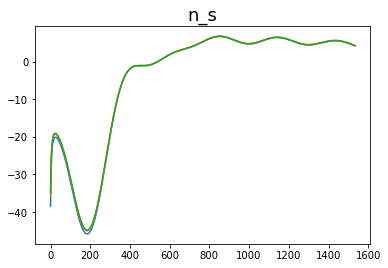

In [149]:
for i,k in enumerate(par.keys()):
    plt.figure()
    plt.title(k,fontsize=18);
    parr=dict(par)
    parr2=dict(par)
    parr[k]=par[k]+sigs[i]
    parr2[k]=par[k]+5*sigs[i]
    m1=(model(parr)['mu'])*ells
    m2=obs['mu']*ells
    m3=(model(parr2)['mu'])*ells
    plt.plot(m1-m2);
    plt.plot((m3-m2)/5);
    plt.plot((m3-m1)/4);

We can normalize by the noise to get the contribution to the likelihood

0.9932029044889193
0.98197868768398
1.0103813860086603
0.9980620230079327
0.9990536219030004


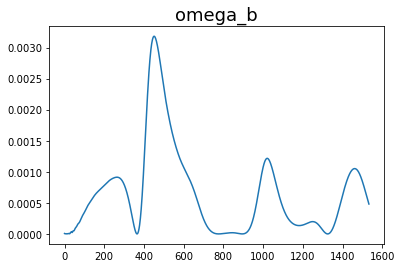

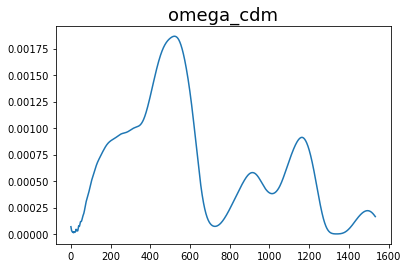

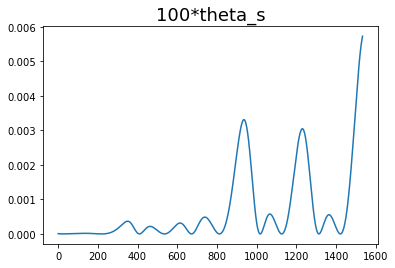

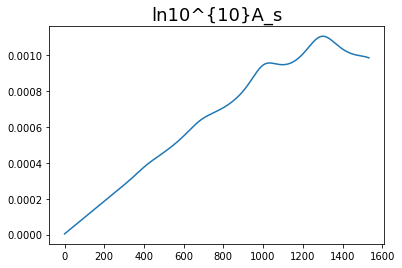

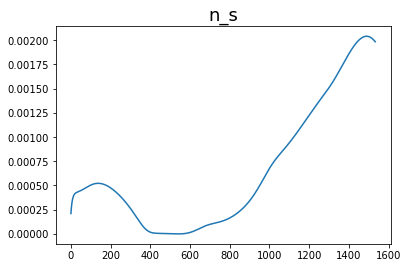

In [150]:
for i,k in enumerate(par.keys()):
    plt.figure()
    plt.title(k,fontsize=18);
    parr=dict(par)
    parr[k]=par[k]+sigE[i]
    m1=(model(parr)['mu'])*ells
    m2=obs['mu']*ells
    d=((m1-m2)/(sigCV*m1))**2
    plt.plot(d);
    print(d.sum())

Plot some ellipses. Purple ellipses are estimates of the $1\sigma$ line of the marginal 2d posterior. Red ellipses imagine all parameters not plotted are fixed to their maximum likelihood value. Note that the min/max values of the purple ellipse for parameter $\theta_i$ correspond to width $\sigma_i=\sqrt{(F^{-1})_{ii}}$.

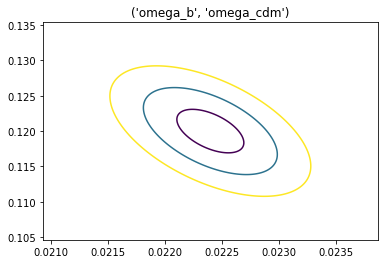

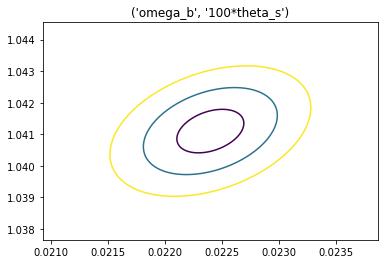

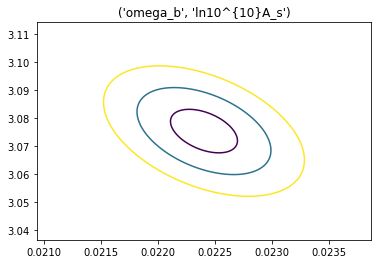

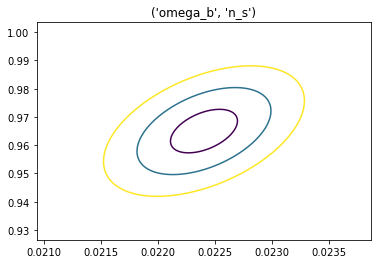

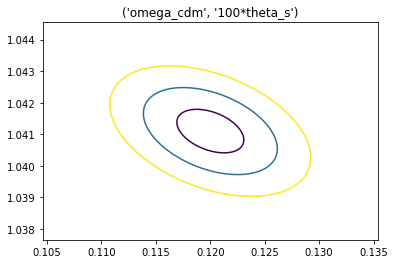

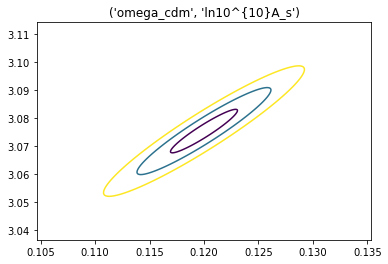

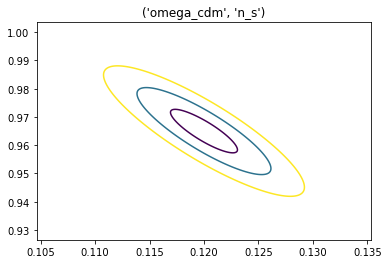

In [366]:
pl=list(par.keys())
for i in range(5):
    for j in range(i+1,5):
        temp=Finv[(np.ix_([i,j],[i,j]))]
        FF=np.linalg.inv(temp)
        y, x = np.ogrid[-5*sigs[j]:5*sigs[j]:1000j, -5*sigs[i]:5*sigs[i]:1000j]
        plt.figure()
        plt.title((list(par.keys())[i],list(par.keys())[j]))
        plt.contour(x.ravel()+par[pl[i]],y.ravel()+par[pl[j]],x**2*FF[0,0]+2 *x*y*FF[0,1]+y**2*FF[1,1],[1,4,9]);
        #plt.contour(x.ravel()+par[pl[i]],y.ravel()+par[pl[j]],x**2*F[i,i]+2 *x*y*F[i,j]+y**2*F[j,j],[1],colors='red');
        #plt.axvline(sigs[i]+par[pl[i]])
        #plt.axvline(sigE[i]+par[pl[i]],color='pink')
        #plt.axhline(par[pl[j]], color='pink')

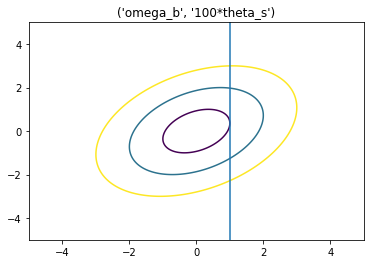

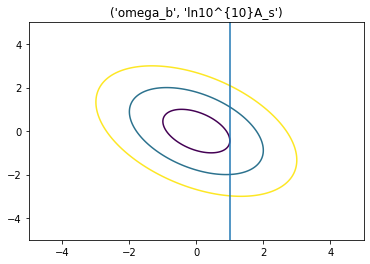

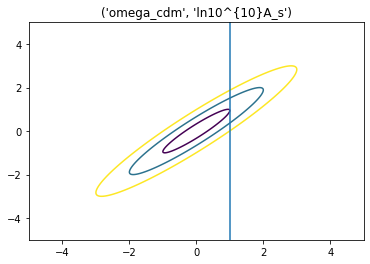

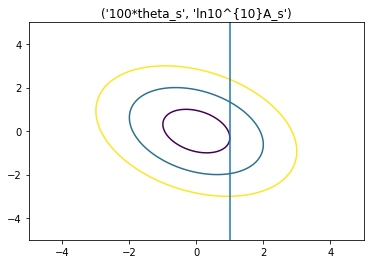

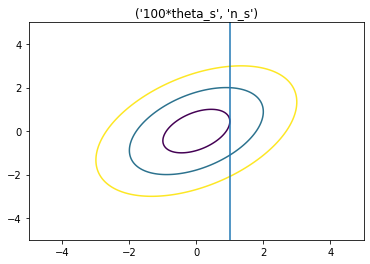

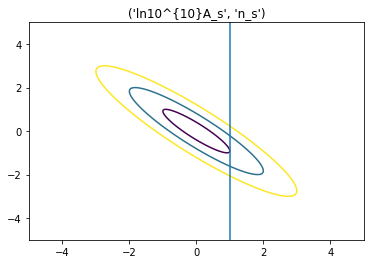

In [369]:
pl=list(par.keys())
for i in range(5):
    for j in range(i+1,5):
        temp=Finv[(np.ix_([i,j],[i,j]))]
        FF=np.linalg.inv(temp)
        y, x = np.ogrid[-5*sigs[j]:5*sigs[j]:1000j, -5*sigs[i]:5*sigs[i]:1000j]
        plt.figure()
        plt.title((list(par.keys())[i],list(par.keys())[j]))
        plt.contour(x.ravel()/sigs[i],y.ravel()/sigs[j],x**2*FF[0,0]+2 *x*y*FF[0,1]+y**2*FF[1,1],[1,4,9]);
        #plt.contour(x.ravel()+par[pl[i]],y.ravel()+par[pl[j]],x**2*F[i,i]+2 *x*y*F[i,j]+y**2*F[j,j],[1],colors='red');
        #plt.axvline(sigs[i]+par[pl[i]])
        #plt.axvline(sigE[i]+par[pl[i]],color='pink')
        #plt.axhline(par[pl[j]], color='pink')
        plt.axvline(1)

Check accuracy of Gaussian approximation... should return a bunch of 1's

In [153]:
for i,k in enumerate(par):
    parr=dict(par)
    parr[k]=par[k]+sigE[i]
    m1=model(parr)['mu']
    print((((m1-obs['mu'])**2)/((sigCV*(obs['mu']))**2)).sum())
    #plt.figure()
    #plt.plot(m1*ells-obs['mu']*ells)
    #print( (m1-obs['mu'])**2) / (((obs['mu']+Nltt)*sigCV))**2)).sum())

0.9905872240400665
0.9767128511958839
1.0058878081485434
1.001432215856862
1.0011925135520576


now $5\sigma$ -- should give $\approx 25$

In [154]:
for i,k in enumerate(par):
    parr=dict(par)
    parr[k]=par[k]+5*sigE[i]
    m1=model(parr)['mu']
    print((((m1-obs['mu'])**2)/((sigCV*(obs['mu']))**2)).sum())
    #plt.figure()
    #plt.plot(m1*ells-obs['mu']*ells)
    #print( (m1-obs['mu'])**2) / (((obs['mu']+Nltt)*sigCV))**2)).sum())

24.747771589195622
24.038876478566717
25.217667557966067
25.211232124887253
25.153865392207358


In [155]:
pdict={}
for i in range(5):
    key=list(par.keys())[i]
    pdict[key] = ['uniform', par[key]-5*sigs[i], par[key]+5*sigs[i]]
print(pdict)
prior=swyft.Prior(pdict)

{'omega_b': ['uniform', 0.020932290217198984, 0.023867709782801016], 'omega_cdm': ['uniform', 0.10462499332979547, 0.13537500667020452], '100*theta_s': ['uniform', 1.0376562262451414, 1.0445437737548584], 'ln10^{10}A_s': ['uniform', 3.036447175506401, 3.114152824493599], 'n_s': ['uniform', 0.9264954731173178, 1.003504526882682]}


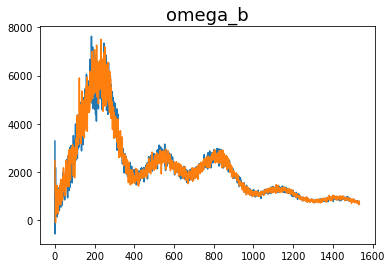

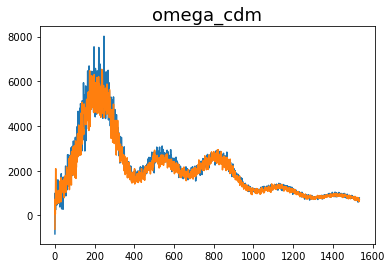

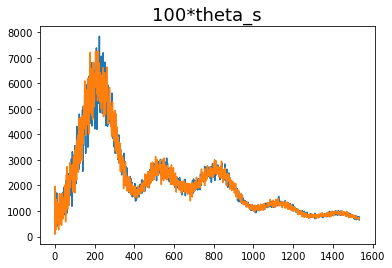

In [261]:
for i,k in enumerate(par.keys()):
    plt.figure()
    plt.title(k,fontsize=18);
    parr=dict(par)
    parr[k]=pdict[k][1]
    plt.plot(noise(model(par))['mu']*ells)
    parr[k]=pdict[k][2]
    plt.plot(noise(model(parr))['mu']*ells)

In [162]:
cache=swyft.DirectoryCache(params=[k for k in par.keys()],obs_shapes={'mu':[1534]}, path='/var/scratch/aecole/cacheCl_5p.zarr')

DEBUG:root:Creating Cache.
DEBUG:root:  params = ['omega_b', 'omega_cdm', '100*theta_s', 'ln10^{10}A_s', 'n_s']
DEBUG:root:  obs_shapes = {'mu': [1534]}


Creating new cache.


# DefaultHead

Start with a pretty small amount of training data

In [262]:
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger.setLevel(logging.DEBUG)

In [263]:
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs,
        device='cuda:0',
        Ninit=5000,
        #Nmax=100000,
        cache=cache,
    )

In [264]:
s.run(
    max_rounds=1,
    train_args={'max_epochs': 50},
    #head=HeadCl
    )

INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 5000
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(1534, [('omega_b',), ('omega_cdm',), ('100*theta_s',), ('ln10^{10}A_s',), ('n_s',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 6.698
DEBUG:root:validation loss = 6.176
DEBUG:root:validation loss = 5.719
DEBUG:root:validation loss = 5.315
DEBUG:root:validation loss = 5.149
DEBUG:root:validation loss = 5.028
DEBUG:root:validation loss = 4.842
DEBUG:root:validation loss = 4.679
DEBUG:root:validation 

In [265]:
samples = s.marginals(obs,50000)

In [267]:
swyft.plot.plot1d(
            samples,
            list(prior.params()),
            figsize=(22, 7),
            ncol=5,
            grid_interpolate=True,
            bins=100,
            truth=par
        )

Looking good!

transform for easier comparison with Fisher expectations

In [268]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

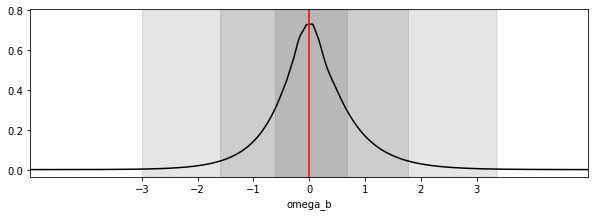

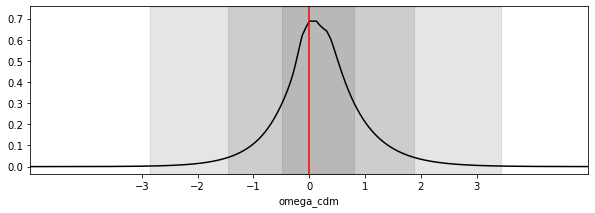

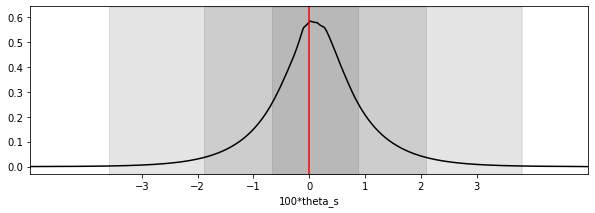

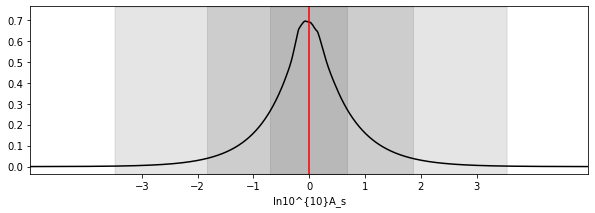

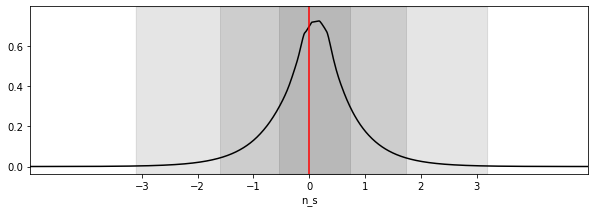

In [269]:
for i in range(5):
    swyft.plot.plot1d(
            samples,
            [list(prior.params())[i]],
            figsize=(10, 3),
            ncol=1,
            grid_interpolate=True,
            #truth={'a': 0, 'b': 0, 'c': 0},
            bins=100
        )
    plt.xticks([-3,-2,-1,0,1,2,3]);
    plt.axvline(0,color='red')

The central values are good. Our credible intervals are a little narrower than expected... give the network more data

In [270]:
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs,
        device='cuda:0',
        Ninit=20000,
        #Nmax=100000,
        cache=cache,
    )

In [271]:
s.run(
    max_rounds=1,
    train_args={'max_epochs': 50},
    #head=HeadCl
    )

INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 20000
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(1534, [('omega_b',), ('omega_cdm',), ('100*theta_s',), ('ln10^{10}A_s',), ('n_s',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 5.297
DEBUG:root:validation loss = 4.688
DEBUG:root:validation loss = 4.584
DEBUG:root:validation loss = 4.441
DEBUG:root:validation loss = 4.407
DEBUG:root:validation loss = 4.373
DEBUG:root:validation loss = 4.313
DEBUG:root:validation loss = 4.283
DEBUG:root:validation

In [272]:
samples = s.marginals(obs,50000)

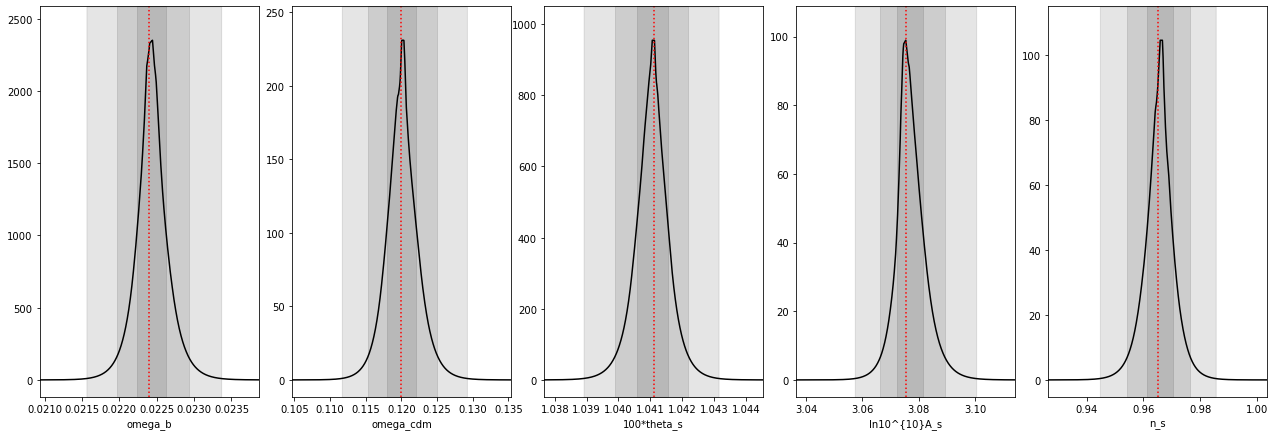

In [273]:
swyft.plot.plot1d(
            samples,
            list(prior.params()),
            figsize=(22, 7),
            ncol=5,
            grid_interpolate=True,
            bins=100,
            truth=par
        )

In [274]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

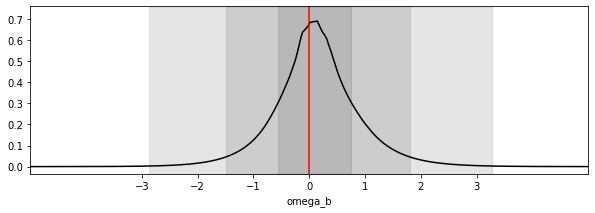

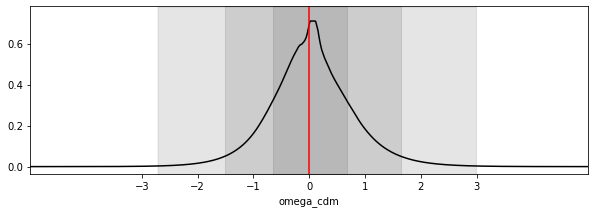

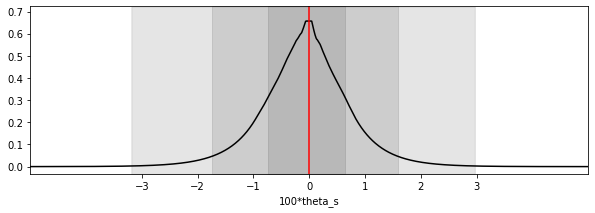

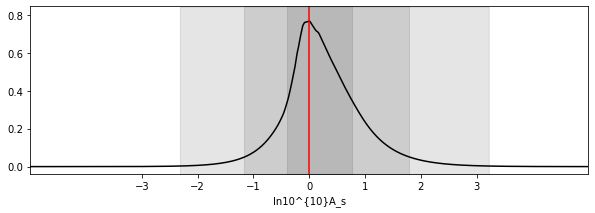

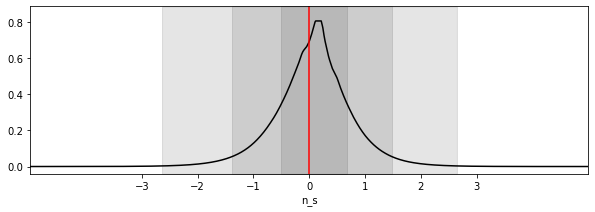

In [275]:
for i in range(5):
    swyft.plot.plot1d(
            samples,
            [list(prior.params())[i]],
            figsize=(10, 3),
            ncol=1,
            grid_interpolate=True,
            #truth={'a': 0, 'b': 0, 'c': 0},
            bins=100
        )
    plt.xticks([-3,-2,-1,0,1,2,3]);
    plt.axvline(0,color='red')

Again we have pretty narrow credible regions... perhaps the network is trying to be too smart.

# Linear compression head

In [284]:
class Head10(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 10

        self.l = torch.nn.Linear(obs['mu'].shape[0], 10)
        self.onl_f = OnlineNormalizationLayer(torch.Size([obs['mu'].shape[0]]))
        

    def forward(self, obs):
        x = obs["mu"]#*Ells
        nbatch = len(x)
        #x = torch.log(0.1+x)
        x=self.onl_f(x)

        x = self.l(x)

        return x

DEBUG:root:Registering new swyft.Module with tag `Head10`


In [285]:
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs,
        device='cuda:0',
        Ninit=5000,
        #Nmax=100000,
        cache=cache,
    )

In [286]:
s.run(
    max_rounds=1,
    train_args={'max_epochs': 50},
    head=Head10
    )

INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 5000
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `Head10`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('omega_b',), ('omega_cdm',), ('100*theta_s',), ('ln10^{10}A_s',), ('n_s',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 5.066
DEBUG:root:validation loss = 4.764
DEBUG:root:validation loss = 4.581
DEBUG:root:validation loss = 4.618
DEBUG:root:lr: 0.0003
DEBUG:root:validation loss = 4.363
DEBUG:root:validation loss = 4.412
DEBUG:root:lr: 0.0001
DEBUG:root:validation loss = 4.383
DEBUG:root:validation loss = 4.443
DEBUG:root:Train losses: [5.7

In [287]:
samples = s.marginals(obs,50000)

In [288]:
swyft.plot.plot1d(
            samples,
            list(prior.params()),
            figsize=(22, 7),
            ncol=5,
            grid_interpolate=True,
            bins=100,
            truth=par
        )

In [289]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

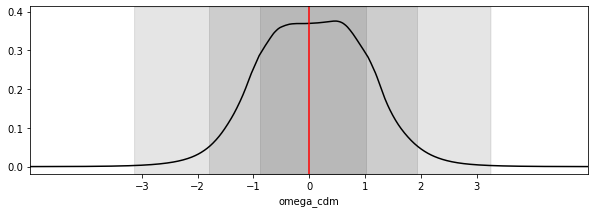

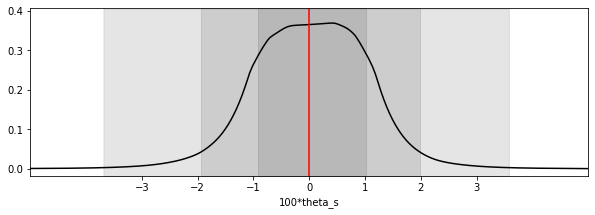

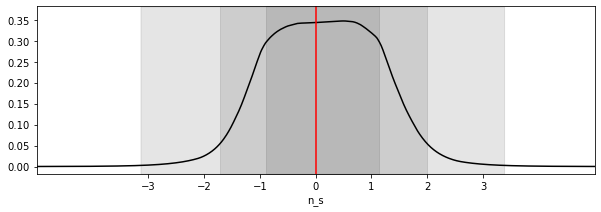

In [290]:
for i in range(5):
    swyft.plot.plot1d(
            samples,
            [list(prior.params())[i]],
            figsize=(10, 3),
            ncol=1,
            grid_interpolate=True,
            #truth={'a': 0, 'b': 0, 'c': 0},
            bins=100
        )
    plt.xticks([-3,-2,-1,0,1,2,3]);
    plt.axvline(0,color='red')

The $1\sigma$ looks nice! Even $2\sigma$ is decent. Let's try a little more data

In [291]:
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs,
        device='cuda:0',
        Ninit=10000,
        #Nmax=100000,
        cache=cache,
    )

In [292]:
s.run(
    max_rounds=1,
    train_args={'max_epochs': 50},
    head=Head10
    )

INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 10000
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `Head10`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('omega_b',), ('omega_cdm',), ('100*theta_s',), ('ln10^{10}A_s',), ('n_s',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 4.501
DEBUG:root:validation loss = 4.199
DEBUG:root:validation loss = 4.235
DEBUG:root:lr: 0.0003
DEBUG:root:validation loss = 4.102
DEBUG:root:validation loss = 4.037
DEBUG:root:validation loss = 4.043
DEBUG:root:lr: 0.0001
DEBUG:root:validation loss = 3.979
DEBUG:root:validation loss = 3.963
DEBUG:root:validation loss =

In [293]:
samples = s.marginals(obs,50000)

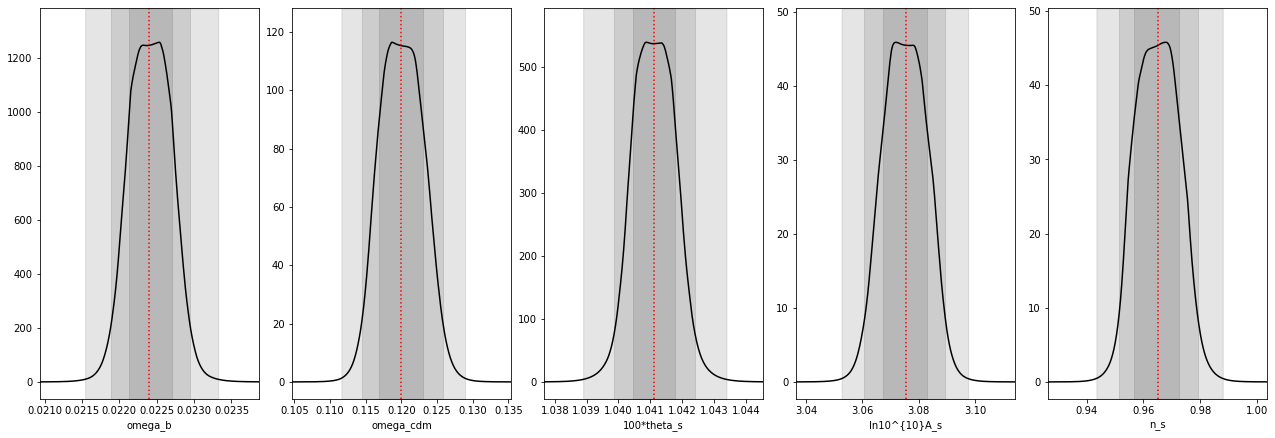

In [294]:
swyft.plot.plot1d(
            samples,
            list(prior.params()),
            figsize=(22, 7),
            ncol=5,
            grid_interpolate=True,
            bins=100,
            truth=par
        )

In [295]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

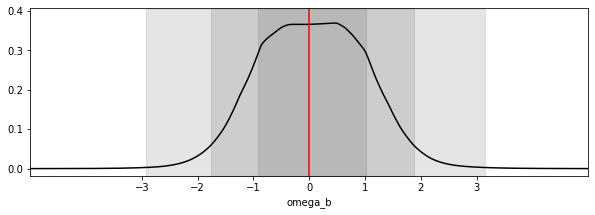

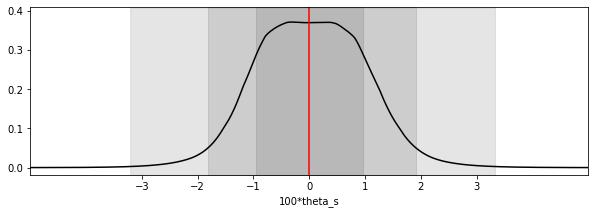

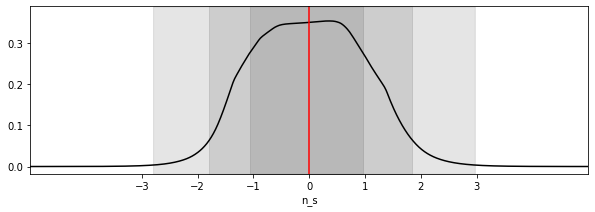

In [296]:
for i in range(5):
    swyft.plot.plot1d(
            samples,
            [list(prior.params())[i]],
            figsize=(10, 3),
            ncol=1,
            grid_interpolate=True,
            #truth={'a': 0, 'b': 0, 'c': 0},
            bins=100
        )
    plt.xticks([-3,-2,-1,0,1,2,3]);
    plt.axvline(0,color='red')

Check the 2d marginals

In [297]:
marginals=s.gen_2d_marginals(N=10000, head=Head10)

INFO:root:Generating marginals for: [('omega_b',), ('omega_b', 'omega_cdm'), ('100*theta_s', 'omega_b'), ('ln10^{10}A_s', 'omega_b'), ('n_s', 'omega_b'), ('omega_cdm',), ('100*theta_s', 'omega_cdm'), ('ln10^{10}A_s', 'omega_cdm'), ('n_s', 'omega_cdm'), ('100*theta_s',), ('100*theta_s', 'ln10^{10}A_s'), ('100*theta_s', 'n_s'), ('ln10^{10}A_s',), ('ln10^{10}A_s', 'n_s'), ('n_s',)]
DEBUG:root:Constrained prior volume = 0.8851
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `Head10`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('omega_b',), ('omega_b', 'omega_cdm'), ('100*theta_s', 'omega_b'), ('ln10^{10}A_s', 'omega_b'), ('n_s', 'omega_b'), ('omega_cdm',), ('100*theta_s', 'omega_cdm'), ('ln10^{10}A_s', 'omega_cdm'), ('n_s', 'omega_cdm'), ('100*theta_s',), ('100*theta_s', 'ln10^{10}A_s'), ('100*theta_s', 'n_s'), ('ln

In [384]:
samples=marginals(obs,200000)

In [385]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

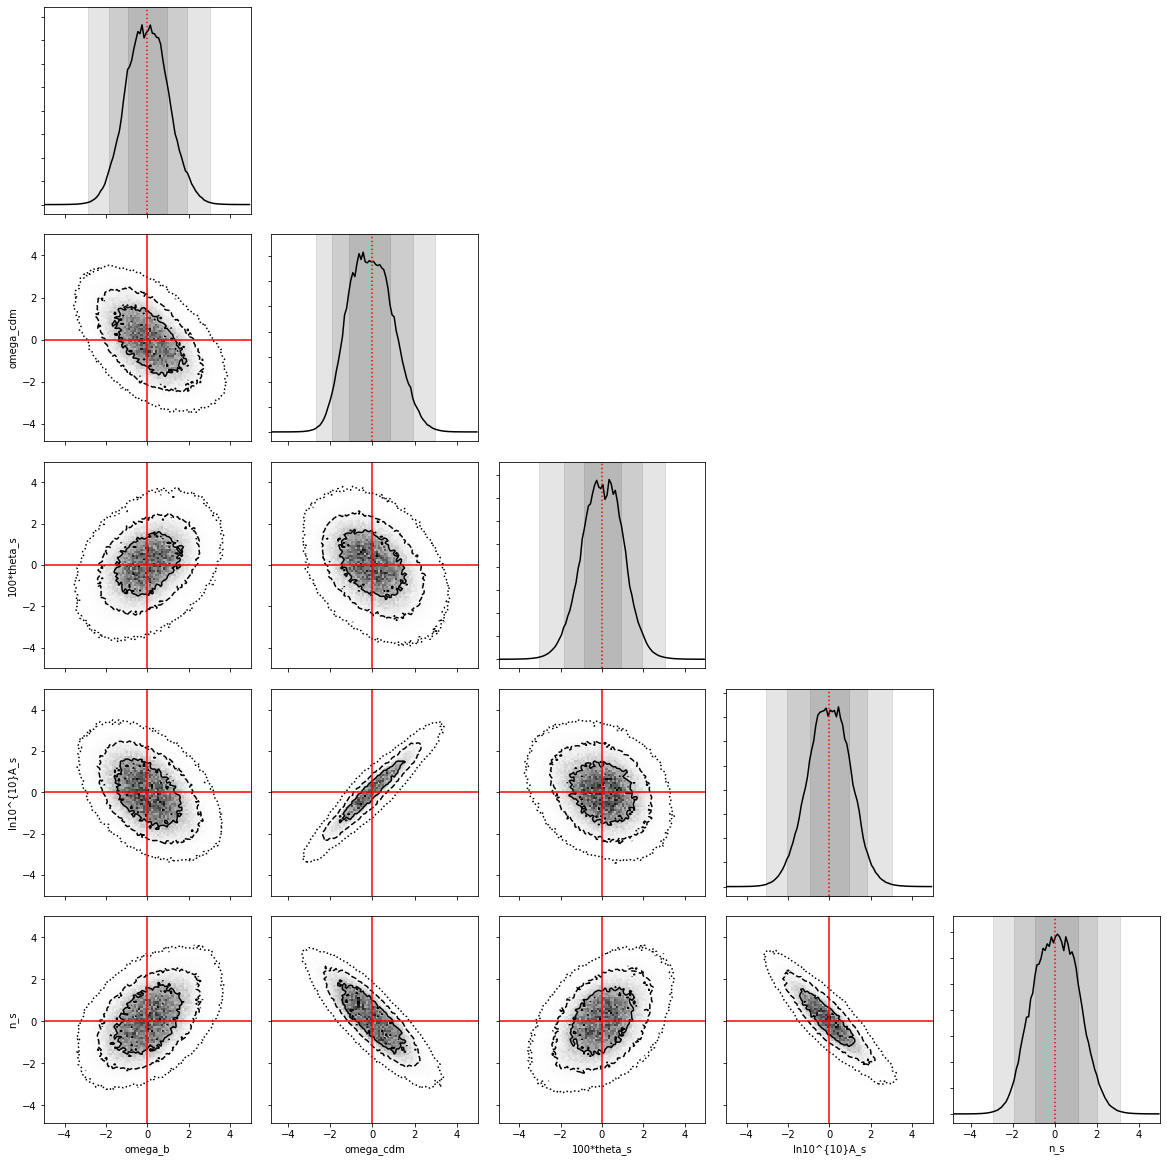

In [386]:
swyft.corner(samples, list(prior.params()), figsize=(20,20),
            #truth=par)
             truth={k:0.0 for k in par.keys()})

modified plotting routine that overlays Fisher contour on 2d plots

In [ ]:

    temp=Finv[(np.ix_([i,j],[i,j]))]
    FF=np.linalg.inv(temp)
    #y, x = np.ogrid[-5*sigs[j]:5*sigs[j]:1000j, -5*sigs[i]:5*sigs[i]:1000j]
    y, x = np.ogrid[-5:5:1000j, -5:5:1000j]
    plt.figure()
    plt.title((list(par.keys())[i],list(par.keys())[j]))
    plt.contour(x.ravel(),y.ravel(),x**2*FF[0,0]+2 *x*y*FF[0,1]+y**2*FF[1,1],[1,4,9]);
    plt.contour(x.ravel(),y.ravel(),x**2*F[i,i]+2 *x*y*F[i,j]+y**2*F[j,j],[1],colors='red');
    plt.axvline(sigs[i])

In [406]:
def cornerF(
    samples,
    params,
    figsize=(10, 10),
    color="k",
    labels=None,
    label_args={},
    truth=None,
    bins=100,
) -> None:
    K = len(params)
    fig, axes = plt.subplots(K, K, figsize=figsize)
    fig.set_facecolor('white')
    lb = 0.125
    tr = 0.9
    whspace = 0.1
    fig.subplots_adjust(
        left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace
    )

    if labels is None:
        labels = [params[i] for i in range(K)]
    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            # Switch off upper left triangle
            if i < j:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
                continue

            # Formatting labels
            if j > 0 or i == 0:
                ax.set_yticklabels([])
                # ax.set_yticks([])
            if i < K - 1:
                ax.set_xticklabels([])
                # ax.set_xticks([])
            if i == K - 1:
                ax.set_xlabel(labels[j], **label_args)
            if j == 0 and i > 0:
                ax.set_ylabel(labels[i], **label_args)

            # Set limits
            # ax.set_xlim(x_lims[j])
            # if i != j:
            #    ax.set_ylim(y_lims[i])

            # 2-dim plots
            if j < i:
                swyft.plot.plot_posterior(
                    samples, [params[j], params[i]], ax=ax, color=color, bins=bins
                )
                if truth is not None:
                    ax.axvline(truth[params[j]], color="r")
                    ax.axhline(truth[params[i]], color="r")
                temp=Finv[(np.ix_([i,j],[i,j]))]
                FF=np.linalg.inv(temp)
                y, x = np.ogrid[-5*sigs[j]:5*sigs[j]:1000j, -5*sigs[i]:5*sigs[i]:1000j]
                #y, x = np.ogrid[-50*sigs[i]:50*sigs[i]:1000j, -50*sigs[j]:50*sigs[j]:1000j]
                ax.contour(x.ravel()/sigs[i],y.ravel()/sigs[j],x**2*FF[0,0]+2*x*y*FF[0,1]+y**2*FF[1,1],[1],
                          colors='blue');
                #plt.contour(x.ravel(),y.ravel(),x**2*F[i,i]+2 *x*y*F[i,j]+y**2*F[j,j],[1],colors='red');
                ax.axvline(1, color='blue')
            if j == i:
                swyft.plot.plot_posterior(samples, params[i], ax=ax, color=color, bins=bins, grid_interpolate=True)
                if truth is not None:
                    ax.axvline(truth[params[i]], ls=":", color="r")
                ax.axvline(1, ls=":", color="purple")

In [407]:
cornerF(samples, list(prior.params()), figsize=(20,20),
            #truth=par)
             truth={k:0.0 for k in par.keys()}, bins=100)
plt.savefig('Head10Corner.png', dpi=300, bbox_inches='tight')

In [ ]:
marginalsBig=s.gen_2d_marginals(N=20000, head=Head10)

INFO:root:Generating marginals for: [('omega_b',), ('omega_b', 'omega_cdm'), ('100*theta_s', 'omega_b'), ('ln10^{10}A_s', 'omega_b'), ('n_s', 'omega_b'), ('omega_cdm',), ('100*theta_s', 'omega_cdm'), ('ln10^{10}A_s', 'omega_cdm'), ('n_s', 'omega_cdm'), ('100*theta_s',), ('100*theta_s', 'ln10^{10}A_s'), ('100*theta_s', 'n_s'), ('ln10^{10}A_s',), ('ln10^{10}A_s', 'n_s'), ('n_s',)]
DEBUG:root:Constrained prior volume = 0.8851
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `Head10`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('omega_b',), ('omega_b', 'omega_cdm'), ('100*theta_s', 'omega_b'), ('ln10^{10}A_s', 'omega_b'), ('n_s', 'omega_b'), ('omega_cdm',), ('100*theta_s', 'omega_cdm'), ('ln10^{10}A_s', 'omega_cdm'), ('n_s', 'omega_cdm'), ('100*theta_s',), ('100*theta_s', 'ln10^{10}A_s'), ('100*theta_s', 'n_s'), ('ln

In [384]:
samples=marginalsBig(obs,200000)

In [385]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

In [ ]:
cornerF(samples, list(prior.params()), figsize=(20,20),
            #truth=par)
             truth={k:0.0 for k in par.keys()}, bins=100)
plt.savefig('Head10CornerBig.png', dpi=300, bbox_inches='tight')

# Convolutional head on direct $C_\ell$

In [167]:
from swyft.nn import OnlineNormalizationLayer

In [27]:
Ells=torch.tensor(ells,dtype=torch.float32).to('cuda:0')

In [168]:
class HeadCl(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 40

        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.conv3 = torch.nn.Conv1d(20, 40, 5)
        self.pool = torch.nn.MaxPool1d(5)
        self.l = torch.nn.Linear(440, 40)
        #self.onl_f = OnlineNormalizationLayer(torch.Size([384]))
        self.onl_f = OnlineNormalizationLayer(torch.Size([1534]))
        

    def forward(self, obs):
        x = obs["mu"]#*Ells
        nbatch = len(x)
        #x = torch.log(0.1+x)
        x=self.onl_f(x)
        x=x.unsqueeze(1)

        x = self.conv1(x)
        x = self.pool(x)
        #x=F.relu(x)
        x = self.conv2(x)
        x = self.pool(x)
        #x=F.relu(x)
        x = self.conv3(x)
        x = self.pool(x)
        #x=F.relu(x)
        x = x.view(nbatch, -1)
        x = self.l(x)

        return x

DEBUG:root:Registering new swyft.Module with tag `HeadCl`


In [36]:
y={'mu': torch.tensor(obs['mu'],dtype=torch.float32).unsqueeze(0)}

In [37]:
HeadCl(torch.Size([1534]))(y).detach().numpy().shape

(1, 40)

In [223]:
#obs=noise(model(par))
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs,
        device='cuda:0',
        Ninit=5000,
        #Nmax=100000,
        cache=cache,
    )

In [224]:
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger.setLevel(logging.DEBUG)

In [225]:
s.run(
    max_rounds=1,
    train_args={'max_epochs': 50},
    #head=HeadCl
    )

INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 5000
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(1534, [('omega_b',), ('omega_cdm',), ('100*theta_s',), ('ln10^{10}A_s',), ('n_s',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 6.694
DEBUG:root:validation loss = 5.982
DEBUG:root:validation loss = 5.428
DEBUG:root:validation loss = 5.154
DEBUG:root:validation loss = 5.029
DEBUG:root:validation loss = 4.74
DEBUG:root:validation loss = 4.685
DEBUG:root:validation loss = 4.704
DEBUG:root:lr: 0.0003
D

In [226]:
#obs2=model(par)
#obs2['mu']=obs2['mu']+Nltt
#samples = s.marginals(noise(model(par)), 10000)
#samples = s.marginals(obs2, 20000)
samples = s.marginals(obs,50000)

In [231]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

In [171]:
pdict

{'omega_b': ['uniform', 0.020619005967671834, 0.024180994032328165],
 'omega_cdm': ['uniform', 0.10626302511578933, 0.13373697488421066],
 '100*theta_s': ['uniform', 1.0376845561021095, 1.0445154438978903],
 'ln10^{10}A_s': ['uniform', 3.0441724764432028, 3.106427523556797],
 'n_s': ['uniform', 0.9163256970878213, 1.0136743029121786]}

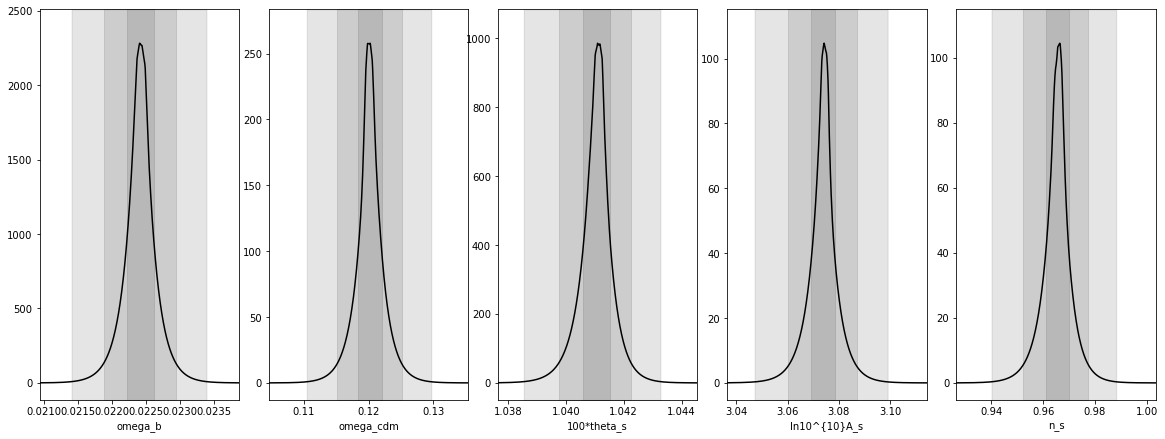

In [230]:
swyft.plot.plot1d(
            samples,
            list(prior.params()),
            figsize=(20, 7),
            ncol=5,
            grid_interpolate=True,
            bins=100
        )

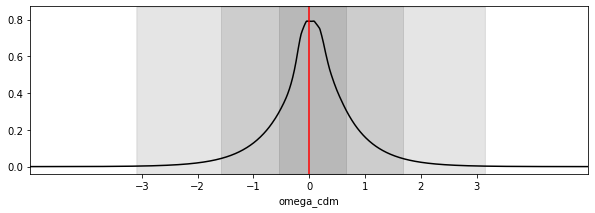

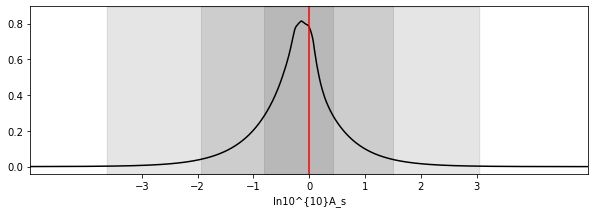

In [233]:
for i in range(5):
    swyft.plot.plot1d(
            samples,
            [list(prior.params())[i]],
            figsize=(10, 3),
            ncol=1,
            grid_interpolate=True,
            #truth={'a': 0, 'b': 0, 'c': 0},
            bins=100
        )
    plt.xticks([-3,-2,-1,0,1,2,3]);
    plt.axvline(0,color='red')

now train with convolutional head

In [241]:
#obs=noise(model(par))
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs,
        device='cuda:0',
        Ninit=10000,
        #Nmax=100000,
        cache=cache,
    )

In [242]:
s.run(
    max_rounds=1,
    train_args={'max_epochs': 50},
    head=HeadCl
    )

INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 10000
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `HeadCl`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(40, [('omega_b',), ('omega_cdm',), ('100*theta_s',), ('ln10^{10}A_s',), ('n_s',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 4.412
DEBUG:root:validation loss = 4.355
DEBUG:root:validation loss = 4.266
DEBUG:root:validation loss = 4.376
DEBUG:root:lr: 0.0003
DEBUG:root:validation loss = 4.24
DEBUG:root:validation loss = 4.175
DEBUG:root:validation loss = 4.204
DEBUG:root:lr: 0.0001
DEBUG:root:validation loss = 4.138
DEBUG:root:validation loss = 

In [251]:
#obs2=model(par)
#obs2['mu']=obs2['mu']+Nltt
samples = s.marginals(model(par), 10000)
#samples = s.marginals(obs2, 20000)
#samples = s.marginals(obs,50000)

In [252]:
samples['params']={k: (samples['params'][k]-par[k])*(1/sigs[i]) for i,k in enumerate(par.keys())}

In [171]:
pdict

{'omega_b': ['uniform', 0.020619005967671834, 0.024180994032328165],
 'omega_cdm': ['uniform', 0.10626302511578933, 0.13373697488421066],
 '100*theta_s': ['uniform', 1.0376845561021095, 1.0445154438978903],
 'ln10^{10}A_s': ['uniform', 3.0441724764432028, 3.106427523556797],
 'n_s': ['uniform', 0.9163256970878213, 1.0136743029121786]}

In [253]:
swyft.plot.plot1d(
            samples,
            list(prior.params()),
            figsize=(20, 7),
            ncol=5,
            grid_interpolate=True,
            bins=100
        )

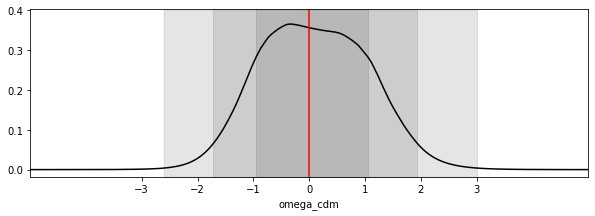

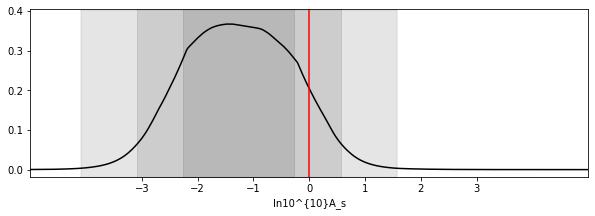

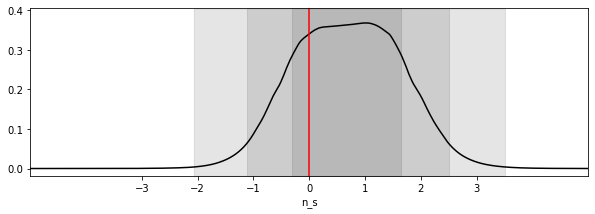

In [254]:
for i in range(5):
    swyft.plot.plot1d(
            samples,
            [list(prior.params())[i]],
            figsize=(10, 3),
            ncol=1,
            grid_interpolate=True,
            #truth={'a': 0, 'b': 0, 'c': 0},
            bins=100
        )
    plt.xticks([-3,-2,-1,0,1,2,3]);
    plt.axvline(0,color='red')

In [255]:
marginals=s.gen_2d_marginals(N=10000, head=HeadCl)

INFO:root:Generating marginals for: [('omega_b',), ('omega_b', 'omega_cdm'), ('100*theta_s', 'omega_b'), ('ln10^{10}A_s', 'omega_b'), ('n_s', 'omega_b'), ('omega_cdm',), ('100*theta_s', 'omega_cdm'), ('ln10^{10}A_s', 'omega_cdm'), ('n_s', 'omega_cdm'), ('100*theta_s',), ('100*theta_s', 'ln10^{10}A_s'), ('100*theta_s', 'n_s'), ('ln10^{10}A_s',), ('ln10^{10}A_s', 'n_s'), ('n_s',)]
DEBUG:root:Constrained prior volume = 0.7461
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `HeadCl`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([1534])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(40, [('omega_b',), ('omega_b', 'omega_cdm'), ('100*theta_s', 'omega_b'), ('ln10^{10}A_s', 'omega_b'), ('n_s', 'omega_b'), ('omega_cdm',), ('100*theta_s', 'omega_cdm'), ('ln10^{10}A_s', 'omega_cdm'), ('n_s', 'omega_cdm'), ('100*theta_s',), ('100*theta_s', 'ln10^{10}A_s'), ('100*theta_s', 'n_s'), ('ln

In [258]:
samples=marginals(obs,50000)

In [51]:
par.keys()

dict_keys(['omega_b', 'omega_cdm', '100*theta_s', 'ln10^{10}A_s', 'n_s', 'tau_reio'])

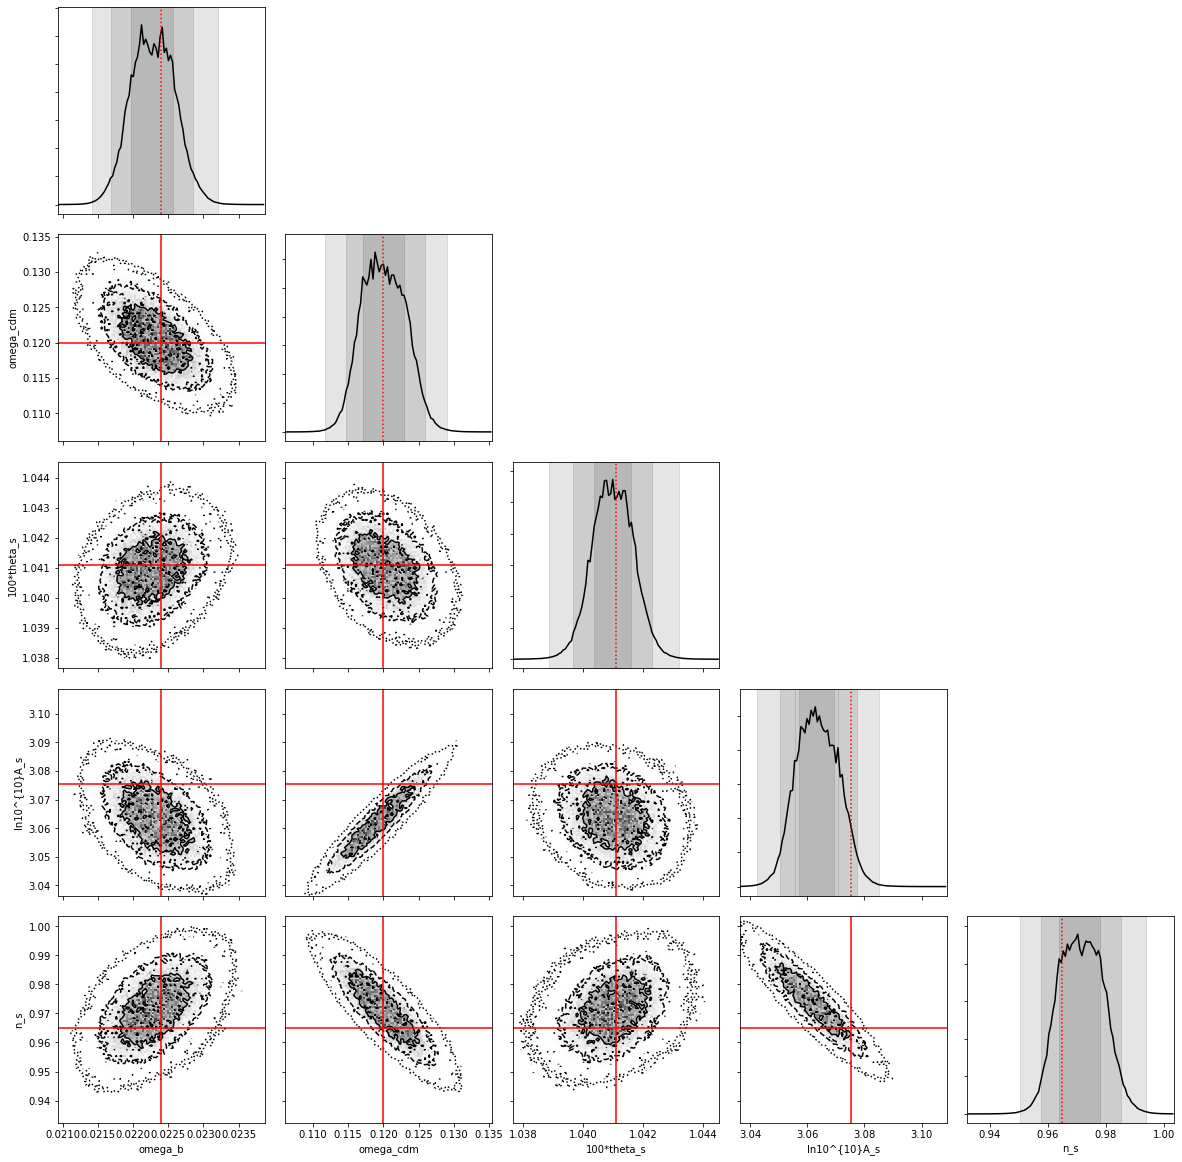

In [259]:
swyft.corner(samples, list(prior.params()), figsize=(20,20),
            truth=par)

In [ ]:
list(prior.params()),
        figsize=(20, 4),
        ncol=6,
        grid_interpolate=True,
        truth=par,

In [ ]:
s.state_dict()

In [58]:
#diagnostics = swyft.utils.sample_diagnostics(samples)
#state_dict = {"NestedRatios": s.state_dict(), "diagnostics": diagnostics}
#torch.save(state_dict, "sample_diagnostics_Cl.pt")

AttributeError: 'NoneType' object has no attribute 'state_dict'

# Convolutional head on Fourier-transformed data

In [23]:
from swyft.nn import OnlineNormalizationLayer

In [24]:
Ells=torch.tensor(ells,dtype=torch.float32).to('cuda:0')

In [ ]:
import torch.nn.functional as F
def unwrap(phi, dim=-1):
    assert dim == -1, 'unwrap only supports dim=-1 for now'
    dphi = diff(phi, same_size=True)
    dphi_m = ((dphi+np.pi) % (2 * np.pi)) - np.pi
    dphi_m[(dphi_m==-np.pi)&(dphi>0)] = np.pi
    phi_adj = dphi_m-dphi
    phi_adj[dphi.abs()<np.pi] = 0
    return phi + phi_adj.cumsum(dim)

def diff(x, dim=-1, same_size=True):
    assert dim == -1, 'diff only supports dim=-1 for now'
    if same_size:
        return F.pad(x[...,1:]-x[...,:-1], (1,0))
    else:
        return x[...,1:]-x[...,:-1]

In [ ]:
class HeadF(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 40

        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.conv3 = torch.nn.Conv1d(20, 40, 5)
        self.pool = torch.nn.MaxPool1d(5)
        self.l = torch.nn.Linear(280, 40)
        
        self.conv4 = torch.nn.Conv1d(1, 10, 5)
        self.conv5 = torch.nn.Conv1d(10, 20, 5)
        self.conv6 = torch.nn.Conv1d(20, 40, 5)
        
        #self.onl_f = OnlineNormalizationLayer(torch.Size([384]))
        self.onl_f = OnlineNormalizationLayer(torch.Size([1000]))
        

    def forward(self, obs):
        x = obs["mu"]*Ells
        nbatch = len(x)
        #x = torch.log(0.1+x)
        x=self.onl_f(x)
        #unsqueeze to generate 1 channel for convolutions
        x=x.unsqueeze(1)
        x=torch.rfft(x)
        

        x = self.conv1(x)
        x = self.pool(x)
        #x=F.relu(x)
        x = self.conv2(x)
        x = self.pool(x)
        #x=F.relu(x)
        x = self.conv3(x)
        x = self.pool(x)
        #x=F.relu(x)
        x = x.view(nbatch, -1)
        x = self.l(x)

        return x

# Simpler data: just $C_\ell$ at $\ell=10,100,1000$ -- experiment "Cl_lite"

In [ ]:
'''simulator'''
ells=np.array([l*(l+1) for l in [10,100,1000]])
ell=np.array([l for l in range(10,100,1000)])
sigCV=np.sqrt(2/(2+ell))
def simulator(omega_b, omega_cdm, n_s, A_s, h, tau_reio, sigma=0.1): 
    params = {
        'output': 'tCl lCl',
        'l_max_scalars': 1000,
        'lensing': 'yes',
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'n_s': n_s,
        'A_s': A_s,
        'h': h,
        'tau_reio': tau_reio
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the whole code. Depending on your output, it will call the
    # CLASS modules more or less fast. For instance, without any
    # output asked, CLASS will only compute background quantities,
    # thus running almost instantaneously.
    # This is equivalent to the beginning of the `main` routine of CLASS,
    # with all the struct_init() methods called.
    cosmo.compute()

    # Access the lensed cl until l=2000
    cls = cosmo.lensed_cl(1000)
    cosmo.struct_cleanup()
    return cls['tt'][np.array([10,100,1000])]*ells*10E9


def model(params):
    """Model wrapper around simulator code."""
    mu = simulator(params['omega_b'], params['omega_cdm'], params['n_s'],params['A_s'],
                  params['h'], params['tau_reio'])
    return dict(mu=mu)

#noise from cosmic variance
def noise(obs, params=None, sigma=1.0):
    """Associated noise model."""
    cltt= obs['mu']
    return {'mu': cltt*(1+np.random.rand(*cltt.shape)*sigCV)}

In [ ]:
prior = swyft.Prior({'omega_b':['normal',0.02249, 0.016*0.01],
                     'omega_cdm':['normal',0.1120,0.0016],
                     'n_s': ['normal', 0.963, 0.004],
                     'A_s': ['normal', 2.42E-9, 0.038E-9],
                     'h': ['normal',0.67, 0.0065],
                     'tau_reio': ['normal', 0.085, 0.0044]
                    })

In [ ]:
par={'omega_b': 0.022765161469578743,
 'omega_cdm': 0.11379978805780411,
 'n_s': 0.9649990797042847,
 'A_s': 2.3952044791997196e-09,
 'h': 0.6607381105422974,
 'tau_reio': 0.08730186522006989}

In [ ]:
cachelite=swyft.DirectoryCache(params=[k for k in par.keys()],obs_shapes={'mu':[3]}, path='cacheCl_lite.zarr')

In [50]:
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs,
        device='cpu',
        Ninit=2000,
        Nmax=100000,
        cache=cachelite,
    )

In [48]:
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger.setLevel(logging.DEBUG)

In [ ]:
s.run(
    max_rounds=15,
    train_args={'early_stopping_patience': 2, 'lr_schedule': [1e-3,1e-4,1e-5],'max_epochs': 100},
    )

# Spherical CNN experiments

In [5]:
theMap=hp.sphtfunc.synfast(cls['tt'],nside=128)

/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [8]:
clsNoise=hp.sphtfunc.anafast(theMap)

In [13]:
clsNoise.shape

(384,)

In [28]:
conv1 = torch.nn.Conv1d(1, 10, 3)
conv2 = torch.nn.Conv1d(10, 20, 3)
conv3 = torch.nn.Conv1d(20, 40, 3)
pool = torch.nn.MaxPool1d(2)

In [29]:
y=torch.tensor(clsNoise,dtype=torch.float32)

In [30]:
y.unsqueeze(0).unsqueeze(1).shape

torch.Size([1, 1, 384])

In [31]:
with torch.no_grad():
    yy=conv1(y.unsqueeze(0).unsqueeze(1))
    yy=pool(yy)
    yy=conv2(yy)
    yy=pool(yy)
    yy=conv3(yy)
    yy=pool(yy)
print(yy.shape)

torch.Size([1, 40, 46])


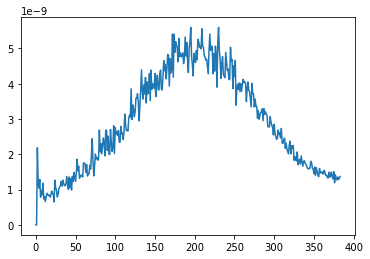

In [12]:
plt.plot(clsNoise*ells[:384])

In [33]:
10E9

10000000000.0

In [ ]:
hp.sphtfunc.anafast(cache[954]['x']['mu']).shape

In [153]:
print(cache[954]['z'],cache[955]['z'],cache[1111]['z'])

{'h': 0.4692871868610382} {'h': 0.6160193681716919} {'h': 0.8553240299224854}


In [166]:
hp.sphtfunc.map2alm(cache[954]['x']['mu'][hp.ring2nest(128,range(196608))])

TypeError: alm2map() missing 1 required positional argument: 'nside'

In [160]:
len(cache[954]['x']['mu'])

196608

In [163]:
cache[954]['x']['mu']

array([ 8.31665783e-06,  1.09884299e-05, -9.36838560e-06, ...,
        6.75923607e-05,  4.09572853e-05,  2.80562016e-05])

In [154]:
plt.plot(hp.sphtfunc.anafast(cache[954]['x']['mu'])*ells[:384]);
plt.plot(hp.sphtfunc.anafast(cache[955]['x']['mu'])*ells[:384]);
plt.plot(hp.sphtfunc.anafast(cache[1111]['x']['mu'])*ells[:384]);

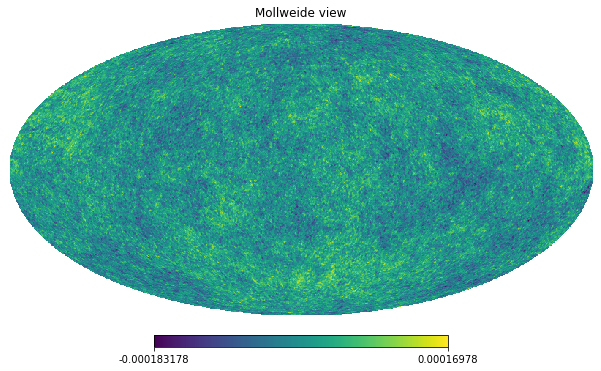

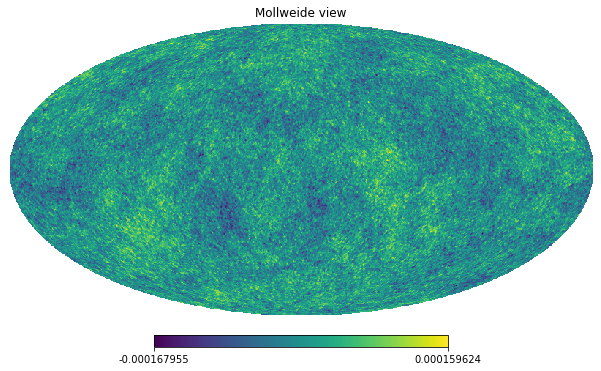

In [156]:
hp.mollview(cache[954]['x']['mu'])
hp.mollview(cache[955]['x']['mu'])
hp.mollview(cache[1111]['x']['mu'])

now define sphere layers

In [25]:
from deepsphere.layers.samplings.healpix_pool_unpool import Healpix
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixMaxPool as hpmp
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixMaxUnpool as hpmup
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixAvgPool as hpap
from deepsphere.layers.samplings.healpix_pool_unpool import HealpixAvgUnpool as hpaup
from deepsphere.utils.laplacian_funcs import get_healpix_laplacians
from deepsphere.layers.chebyshev import SphericalChebConv

In [26]:
#bugfix for hpmp
import torch.nn.functional as F
class HealpixMaxPool(torch.nn.MaxPool1d):
    """Healpix Maxpooling module
    """

    def __init__(self, return_indices=False):
        """Initialization
        """
        super().__init__(kernel_size=4, return_indices=return_indices)

    def forward(self, x):
        """Forward call the 1d Maxpooling of pytorch

        Args:
            x (:obj:`torch.tensor`):[batch x pixels x features]

        Returns:
            tuple((:obj:`torch.tensor`), indices (int)): [batch x pooled pixels x features] and indices of pooled pixels
        """
        x = x.permute(0, 2, 1)
        if self.return_indices:
            x, indices = F.max_pool1d(x, self.kernel_size)
        else:
            x = F.max_pool1d(x,self.kernel_size)
        x = x.permute(0, 2, 1)

        if self.return_indices:
            output = x, indices
        else:
            output = x
        return output

In [28]:
x=[1]*(12*128**2)
y=torch.tensor(x,dtype=torch.float32)

In [29]:
y.unsqueeze(-1).shape

torch.Size([196608, 1])

In [30]:
y=y.unsqueeze(0).unsqueeze(-1)
print(y.shape)

torch.Size([1, 196608, 1])


In [31]:
from pygsp.graphs.nngraphs.spherehealpix import SphereHealpix
from deepsphere.utils.laplacian_funcs import prepare_laplacian

from deepsphere.utils.samplings import (
    healpix_resolution_calculator
)
def get_healpix_laplacians(nodes, depth, laplacian_type):
    """Get the healpix laplacian list for a certain depth.
    Args:
        nodes (int): initial number of nodes.
        depth (int): the depth of the UNet.
        laplacian_type ["combinatorial", "normalized"]: the type of the laplacian.
    Returns:
        laps (list): increasing list of laplacians.
    """
    laps = []
    for i in range(depth):
        pixel_num = nodes
        resolution = int(healpix_resolution_calculator(pixel_num)/2**i)
        G = SphereHealpix(nside=resolution, n_neighbors=8)
        G.compute_laplacian(laplacian_type)
        laplacian = prepare_laplacian(G.L)
        laps.append(laplacian)
    return laps[::-1]

In [108]:
laps=get_healpix_laplacians(12*128**2,7,"normalized")


In [105]:
laps[1:]

[tensor(indices=tensor([[  0,   0,   0,  ..., 767, 767, 767],
                        [  0,   1,   2,  ..., 765, 766, 767]]),
        values=tensor([ 0.3151, -0.2466, -0.2466,  ..., -0.2466, -0.2466,
                        0.3151]),
        size=(768, 768), nnz=7032, layout=torch.sparse_coo),
 tensor(indices=tensor([[   0,    0,    0,  ..., 3071, 3071, 3071],
                        [   0,    1,    2,  ..., 3069, 3070, 3071]]),
        values=tensor([ 0.2787, -0.2390, -0.2390,  ..., -0.2390, -0.2390,
                        0.2787]),
        size=(3072, 3072), nnz=27960, layout=torch.sparse_coo),
 tensor(indices=tensor([[    0,     0,     0,  ..., 12287, 12287, 12287],
                        [    0,     1,     2,  ..., 12285, 12286, 12287]]),
        values=tensor([ 0.2595, -0.2352, -0.2352,  ..., -0.2352, -0.2352,
                        0.2595]),
        size=(12288, 12288), nnz=111608, layout=torch.sparse_coo),
 tensor(indices=tensor([[    0,     0,     0,  ..., 49151, 49151, 4915

In [109]:
spch1 = SphericalChebConv(1, 10, laps[-1], kernel_size=3)
spch2 = SphericalChebConv(10, 20, laps[-2], kernel_size=3)
spch3 = SphericalChebConv(20, 40, laps[-3], kernel_size=3)
spch4 = SphericalChebConv(40, 80, laps[-4], kernel_size=3)
spch5 = SphericalChebConv(80, 160, laps[-5], kernel_size=3)
spch6 = SphericalChebConv(160, 320, laps[-6], kernel_size=3)
spch7 = SphericalChebConv(320, 640, laps[-7], kernel_size=3)
pool = HealpixMaxPool()
#pool=hpap()

In [110]:
with torch.no_grad():
    yy=spch1(y)
    yy=pool(yy)
    yy=spch2(yy)
    yy=pool(yy)
    yy=spch3(yy)
    yy=pool(yy)
    yy=spch4(yy)
    yy=pool(yy)
    yy=spch5(yy)
    yy=pool(yy)
    yy=spch6(yy)
    yy=pool(yy)
    yy=spch7(yy)
    yy=pool(yy)
    zz=torch.softmax(yy,dim=1)

In [111]:
yy.shape

torch.Size([1, 12, 640])

In [112]:
y.shape

torch.Size([1, 196608, 1])

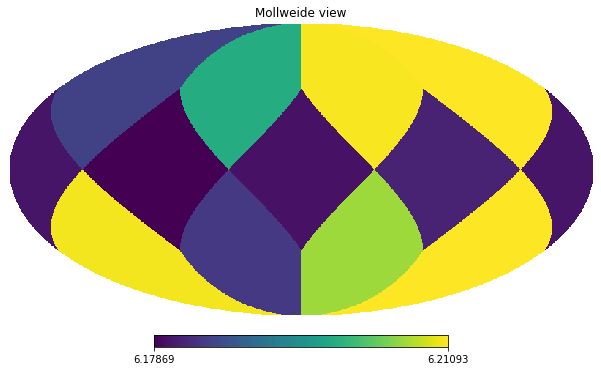

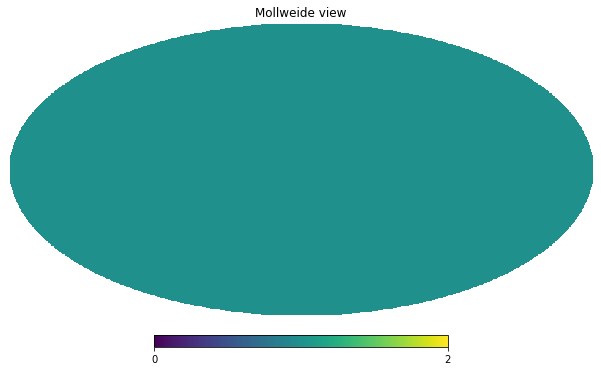

In [114]:
hp.mollview(yy[0,:,0])
hp.mollview(zz[0,:,0])
hp.mollview(y[0,:,0])

In [123]:
from deepsphere.layers.chebyshev import ChebConv
NSIDE=128
laps=get_healpix_laplacians(12*NSIDE**2,7,"normalized")
llaps1=laps[-1].cuda()
llaps2=laps[-2].cuda()
llaps3=laps[-3].cuda()
llaps4=laps[-4].cuda()
llaps5=laps[-5].cuda()
llaps6=laps[-6].cuda()
llaps7=laps[-7].cuda()

class CustomHead(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 12*640

        #self.spch1 = SphericalChebConv(1, 10, laps[-1], kernel_size=3)
        #self.spch2 = SphericalChebConv(10, 20, laps[-2], kernel_size=3)
        #self.spch3 = SphericalChebConv(20, 40, laps[-3], kernel_size=3)
        self.spch1 = ChebConv(1, 10, kernel_size=5)
        self.spch2 = ChebConv(10, 20, kernel_size=5)
        self.spch3 = ChebConv(20, 40, kernel_size=5)
        self.spch4 = ChebConv(40, 80, kernel_size=5)
        self.spch5 = ChebConv(80, 160, kernel_size=5)
        self.spch6 = ChebConv(160, 320, kernel_size=5)
        self.spch7 = ChebConv(320, 640, kernel_size=5)
        self.pool = HealpixMaxPool()
        #self.l = torch.nn.Linear(192*40, 1000)
        #self.onl_f = OnlineNormalizationLayer(torch.Size([196608]))

    def forward(self, obs):
        '''input has shape [n_batch, n_pixel]
            which we map to [n_batch, n_pixel, n_channel=1] before entering the convolutional/pooling layers
            at the end we output a shape [n_batch, n_features]
        '''
        x = obs["mu"]
        nbatch = len(x)
        #x = torch.log(0.1+x)
        #x=self.onl_f(x)
        x=x.unsqueeze(-1)

        x = self.spch1(llaps1,x)
        x = self.pool(x)
        x = self.spch2(llaps2,x)
        x = self.pool(x)
        x = self.spch3(llaps3,x)
        x = self.pool(x)
        x = self.spch4(llaps4,x)
        x = self.pool(x)
        x = self.spch5(llaps5,x)
        x = self.pool(x)
        x = self.spch6(llaps6,x)
        x = self.pool(x)
        x = self.spch7(llaps7,x)
        x = self.pool(x)
        x=torch.softmax(x,dim=1)
        x = x.view(nbatch, -1)
        #x = self.l(x)

        return x

In [118]:
prior

In [120]:
obs0=model({'h':0.67})

In [124]:
s = swyft.NestedRatios(
        model,
        prior,
        noise=noise,
        obs=obs0,
        device='cuda:0',
        Ninit=3000,
        Nmax=100000,
        cache=cache,
    )

In [126]:
import logging

logging.basicConfig(level=logging.DEBUG, format="%(message)s")

In [128]:
s.run(
        max_rounds=10,
        train_args={'lr_schedule': [1e-3,1e-4]},
        head=CustomHead,
        #head=defs.HeadCl,
        tail_args={},
        head_args={},
    )

In [130]:
samples = s.marginals(obs0, 30000)

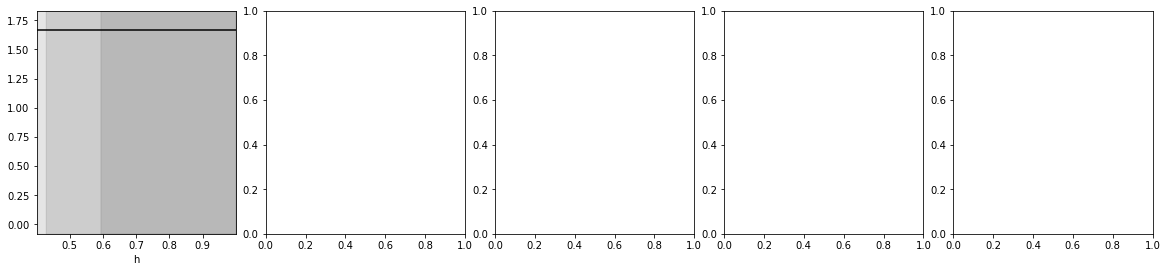

In [132]:
swyft.plot.plot1d(
        samples,
        list(prior.params()),
        figsize=(20, 4),
        ncol=5,
        grid_interpolate=True,
        #truth=par0,
    )

In [133]:
torch.cuda.empty_cache()